In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import os
from fastai import *
from fastai.vision import *

image_folder = '1024/image_dir_processed'

os.chdir("/home/auri/")
os.getcwd()

'/home/auri'

In [3]:
df = pd.read_csv('Rx-thorax-automatic-captioning/SJ_chest_x_ray_images_labels_160K_Ene19.csv', header = 0, dtype=str)
df.columns

Index(['Unnamed: 0', 'ImageID', 'ImageDir', 'StudyDate_DICOM', 'StudyID',
       'PatientID', 'PatientBirth', 'PatientSex_DICOM', 'ViewPosition_DICOM',
       'Projection', 'MethodProjection', 'Pediatric', 'Modality_DICOM',
       'Manufacturer_DICOM', 'PhotometricInterpretation_DICOM',
       'PixelRepresentation_DICOM', 'PixelAspectRatio_DICOM',
       'SpatialResolution_DICOM', 'BitsStored_DICOM', 'WindowCenter_DICOM',
       'WindowWidth_DICOM', 'Rows_DICOM', 'Columns_DICOM',
       'XRayTubeCurrent_DICOM', 'Exposure_DICOM', 'ExposureInuAs_DICOM',
       'ExposureTime', 'RelativeXRayExposure_DICOM', 'ReportID', 'Report',
       'MethodLabel', 'Labels', 'Localizations',
       'LabelsLocalizationsBySentence', 'labelCUIS', 'LocalizationsCUIS'],
      dtype='object')

In [4]:
#create field with labels flattened to a single sequence
import ast
def delabel(labels):
    r = None
    if labels is not None:
        try:
            r = pd.Series([label.strip() for label in  ast.literal_eval(labels)]).dropna().values
        except:
            r = None
    return r
    
df.loc[:,'labels'] = df.loc[:,'Labels'].apply(lambda l: delabel(l))

In [5]:
#create field with labels and locations  flattened to a single sequence
#uncomment only to train a model to predict both labels and locations
def delabel_loc(labels):
    r = None
    if labels is not None:
        try:
            r = pd.Series([label.replace('loc ','').strip() for sublist in  ast.literal_eval(labels) for label in sublist]).dropna().values
        except:
            r = None
    return r
    
#df.loc[:,'labelslocs'] = df.loc[:,'LabelsLocalizationsBySentence'].apply(lambda l: delabel_loc(l))




In [6]:
#Reports null are filtered (n = 103)
df_fastai = df.loc[df.labels.isna() == False,['ImageID','labels','LabelsLocalizationsBySentence','Projection','Pediatric', 'StudyDate_DICOM', 'PatientBirth','MethodLabel', 'PatientID']]
print(df_fastai.shape)

(160758, 9)


In [7]:
#corrupted images are filtered (n < 40)
corrupt_images = pd.read_csv('SJ/badfiles__.txt', dtype=str)
corrupt_images = corrupt_images.iloc[:,0].str.replace(image_folder,'').str.replace("'",'').values

df_fastai = df_fastai.loc[df_fastai.ImageID.isin(corrupt_images) == False,:]
df_fastai.shape

(160758, 9)

In [8]:
import glob
filter_images = pd.Series(glob.glob(f"/home/auri/SJ/{image_folder}/*.png")).str.replace(f'/home/auri/SJ/{image_folder}/','')
print(filter_images.describe())
df_fastai = df_fastai.loc[df_fastai.ImageID.isin(filter_images),]
df_fastai.shape

count                                                167257
unique                                               167257
top       216840111366964013200840352202011314122651899_...
freq                                                      1
dtype: object


(160725, 9)

In [9]:
#Pediatric images are filtered
df_fastai = df_fastai.loc[df_fastai['Pediatric'] != 'PED',]
print(df_fastai.shape)
df_fastai.head()

#In many pediatric images (n aprox 3300), none of the DICOM field are tagged as pediatric, so as an additional measure we remove patients less than 5 years old
#StudyDate_DICOM PatientBirth
df_fastai['age'] = df_fastai.StudyDate_DICOM.str.slice(0, 4).astype('float') - df_fastai.PatientBirth.astype('float') 

df_fastai =df_fastai.loc[df_fastai['age'] > 5.0,]
print(df_fastai.shape)

(160451, 9)
(157096, 10)


In [10]:
patho_list = ["atelectasis", "cardiomegaly", "cardiac", 
              "pleural effusion", "infiltrates", "mass", "nodule",
             "pneumonia", "pneumothorax", 
              "consolidation", "pulmonary edema",
             "emphysema", "pulmonary fibrosis", "pleural thickening",
             "hiatal hernia", "granuloma", "chronic changes", #scaring is not exactly equal to chronic changes, but more to fibrosis, but PLCO has other term with fibrosis
              "bone", "soft tissue",
             "COPD signs", "hilar", "normal"]

#Frontal images are selected
print(df_fastai.Projection.value_counts())
frontal = ['PA', 'AP_horizontal', 'AP']
df_fastai = df_fastai.loc[df_fastai['Projection'].isin(frontal),['ImageID','labels','Projection','Pediatric','MethodLabel', 'PatientID','LabelsLocalizationsBySentence']]
print(df_fastai.shape)


#"exclude" labeled reports  are filtered
df_fastai = df_fastai[~ df_fastai.labels.map(lambda x: 'exclude'  in x and x.shape[0] == 1)]
print(df_fastai.shape)

#"suboptimal study" reported images are filtered
df_fastai = df_fastai[~ df_fastai.labels.map(lambda x: 'suboptimal study'  in x and x.shape[0] == 1)]
print(df_fastai.shape)



#create new pandas with field "normal" True or False
normal = df_fastai[df_fastai.labels.map(lambda x: 'normal'  in x and x.shape[0] == 1)]
print(normal.shape)
df_fastai_normal = df_fastai[['ImageID','labels','LabelsLocalizationsBySentence']]
df_fastai_normal.loc[:,'Normal'] = False
df_fastai_normal.loc[df_fastai.labels.map(lambda x: 'normal'  in x and x.shape[0] == 1),'Normal' ] = True

print(df_fastai_normal.head())


PA               90375
L                48956
AP_horizontal    13690
AP                3446
COSTAL             618
EXCLUDE             11
Name: Projection, dtype: int64
(107511, 7)
(106581, 7)
(106308, 7)
(34966, 7)


/home/auri/anaconda3/envs/fastai-Ene19/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/auri/anaconda3/envs/fastai-Ene19/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


                                             ImageID  \
0  20536686640136348236148679891455886468_k6ga29.png   
2  135803415504923515076821959678074435083_fzis7b...   
3  113855343774216031107737439268243531979_3k951l...   
5  313903302629300007485735352869488750471_75sg0k...   
7  3137231742710829928-247610802266403640553_kine...   

                                              labels  \
0                                           [normal]   
2  [pulmonary fibrosis, chronic changes, kyphosis...   
3                                  [chronic changes]   
5  [unchanged, alveolar pattern, interstitial pat...   
7  [laminar atelectasis, pleural effusion, apical...   

                       LabelsLocalizationsBySentence  Normal  
0                           [['normal'], ['normal']]    True  
2  [['pulmonary fibrosis', 'loc basal bilateral']...   False  
3  [['chronic changes'], ['chronic changes'], ['n...   False  
5  [['unchanged'], ['alveolar pattern', 'intersti...   False  
7  [['lamin

In [11]:
#filter physician labeled
#df_fastai_filter = df_fastai.loc[df_fastai.MethodLabel.isin(['Physician']), ['ImageID','labels']]
#print(df_fastai_filter.columns)
#df_fastai_filter.reset_index(inplace = True, drop=True)
#df_fastai_filter.head()

#filter pneumothorax and select equal number of normal to balance
f = ['pneumothorax']
df_fastai_p = df_fastai.loc[df_fastai.labels.map(lambda x: 'pneumothorax'  in x ), ['ImageID','labels', 'PatientID','LabelsLocalizationsBySentence']]
df_fastai_p['pneumothorax'] = True
print(df_fastai_p.shape)
normal = df_fastai_normal.loc[df_fastai_normal.Normal == True,][:df_fastai_p.shape[0]]
normal['pneumothorax'] = False


(323, 5)


In [12]:
#split by patient so that the same patient is on either training or val set but never on both
unique = df_fastai_p.PatientID.value_counts()
multiple = unique.loc[unique > 1]
unique = unique.loc[unique == 1]


#strategy: add multiple observations of patients only to the training set following same principle as augmentation
train = df_fastai_p.loc[df_fastai_p.PatientID.isin(multiple.index),]

unique_p = df_fastai_p.loc[df_fastai_p.PatientID.isin(unique.index),]


#complete  up to the rest
n = int(df_fastai_p.shape[0] * 0.8)
_rest = n - train.shape[0]
add_train = unique_p[:_rest][['ImageID','labels','PatientID','pneumothorax','LabelsLocalizationsBySentence']]
print(add_train.shape[0])
normal_train = normal[:n]
train = pd.concat([train, add_train, normal_train])

train = train[['ImageID','labels','pneumothorax','PatientID','LabelsLocalizationsBySentence']]

normal_val = normal[n:]
val = unique_p[_rest:][['ImageID','labels','PatientID','pneumothorax','LabelsLocalizationsBySentence']]
val = pd.concat([val, normal_val])
val = val[['ImageID','labels','pneumothorax','PatientID','LabelsLocalizationsBySentence']]

print(train.shape)
print(train.PatientID.value_counts())
print(val.PatientID.value_counts())
print(val.shape)

df_final = pd.concat([ train,val], ignore_index=True)

print(df_final)

#df_final = pd.concat([df_fastai_p, normal])
#df_final.reset_index(inplace= True, drop=True)
#df_final = df_final[['ImageID','labels','pneumothorax']]



65
(516, 5)
329094864679344259970183492645597011898    7
69724957773614891038390578548808835262     6
326073745626371540089876000693490142098    5
322005813391258427687725731946549054641    5
274050221548269568238943111121762285728    4
208726526550423772016725049710490034211    4
178126095015874490624294255423150841170    4
21253920840331003345282050905764473306     4
62612688296225212740624943745445315947     3
309636446149935895277839372489562527851    3
146454251231523038216451059366081930951    3
2335461439019297369030106805057490830      3
71188235225812915740908786470645658958     3
132309184169117439129083440727851576855    3
234484329890620064175890077617441069640    3
307185301817457428093560071146170132214    3
237661526842625330249973312139309570528    3
193768806617822154791158101577292988218    3
289353910114757870400306229090284532324    3
22665570420535441710797662184975984797     3
68704669253336537990083346053667734284     3
117439012308969437544968574801907696296    

/home/auri/anaconda3/envs/fastai-Ene19/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/auri/anaconda3/envs/fastai-Ene19/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [13]:
#from sklearn.model_selection import train_test_split
#train, val = train_test_split(df_final, random_state=42, test_size=0.2, shuffle=True)

In [14]:
n = int(df_final.shape[0] * 0.8)
train = df_final[:n]
val = df_final[n:]
print(train.PatientID.value_counts())
print(val.PatientID.value_counts())

329094864679344259970183492645597011898    7
69724957773614891038390578548808835262     6
326073745626371540089876000693490142098    5
322005813391258427687725731946549054641    5
274050221548269568238943111121762285728    4
208726526550423772016725049710490034211    4
178126095015874490624294255423150841170    4
21253920840331003345282050905764473306     4
62612688296225212740624943745445315947     3
309636446149935895277839372489562527851    3
146454251231523038216451059366081930951    3
2335461439019297369030106805057490830      3
71188235225812915740908786470645658958     3
132309184169117439129083440727851576855    3
234484329890620064175890077617441069640    3
307185301817457428093560071146170132214    3
237661526842625330249973312139309570528    3
193768806617822154791158101577292988218    3
289353910114757870400306229090284532324    3
22665570420535441710797662184975984797     3
68704669253336537990083346053667734284     3
117439012308969437544968574801907696296    3
4927766385

In [15]:
import cv2
def open_png16(self, fn):
    img = cv2.imread(str(fn), cv2.IMREAD_UNCHANGED).astype(np.float32)/65535
    #img = cv2.resize(img, (224,224))
    return Image(torch.tensor(img).unsqueeze(0).expand((3,-1,-1)))
#open_png16(fn ="SJ/image_dir_processed/113855343774216031107737439268243531979_3k951l.png")

In [16]:
#Replace with the path to image folder 
p = "/home/auri/SJ/"
bach_size = 16

In [17]:
import cv2
class MyImageItemList(ImageItemList):
    def open(self,fn):
        img = None
        try:
            img = cv2.imread(str(fn), cv2.IMREAD_UNCHANGED).astype(np.float32)/65535
        except:
            print(fn)
        #img = cv2.resize(img, (224,224))
        return Image(torch.tensor(img).unsqueeze(0).expand((3,-1,-1)))

In [18]:
data = (MyImageItemList.from_df(
    df = df_final, path = p, 
    folder=image_folder).split_by_idx(valid_idx=val.index.values).label_from_df(
    cols='pneumothorax').transform(
    get_transforms(do_flip = False, max_rotate = 5.0, max_zoom = 0, max_warp = None), 
    size=(1500,1500)).databunch(bs=bach_size).normalize())                          


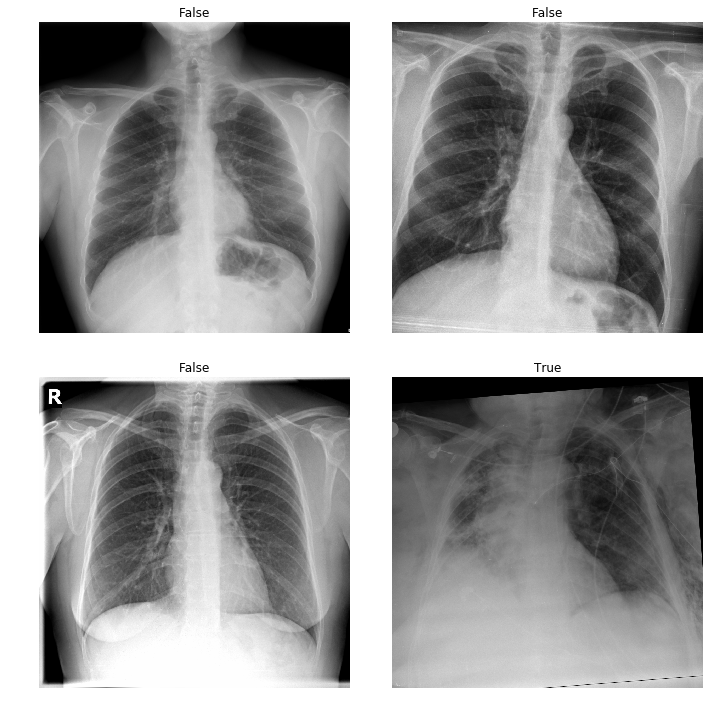

In [19]:
data.show_batch(rows=2, figsize=(10,10))


In [22]:
data.classes

[False, True]

False
ImageID                          54725168636088064269989216447556588851_em4uso.png
labels                                                                    [normal]
pneumothorax                                                                 False
PatientID                                                                      NaN
LabelsLocalizationsBySentence                                         [['normal']]
Name: 640, dtype: object


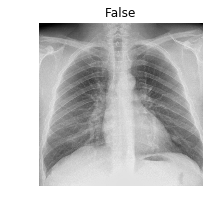

In [23]:
#show one study example from validation set
img,labels = data.valid_ds[-6]
print(labels)
print(df_final.loc[val.index.values[-6],])
img.show(title=labels)


In [24]:
class AverageMetric(Callback):
    def __init__(self, func):
        self.func, self.name = func, func.__name__

    def on_epoch_begin(self, **kwargs):
        self.val, self.count = 0.,0

    def on_batch_end(self, last_output, last_target, train, **kwargs):
        self.count += last_target.size(0)
        self.val += last_target.size(0) * self.func(last_output, last_target).detach().item()

    def on_epoch_end(self, **kwargs):
        self.metric = self.val/self.count


In [25]:
class Precision(Callback):
    
    def on_epoch_begin(self, **kwargs):
        self.correct, self.total = 0, 0
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        preds = last_output.argmax(1)
        self.correct += ((preds==1) * (last_target==1)).float().sum()
        self.total += (preds==1).float().sum()
    
    def on_epoch_end(self, **kwargs):
        self.metric = self.correct/self.total
        
class Recall(Callback):
    
    def on_epoch_begin(self, **kwargs):
        self.correct, self.total = 0, 0
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        preds = last_output.argmax(1)
        self.correct += ((preds==1) * (last_target==1)).float().sum()
        self.total += (last_target==1).float().sum()
    
    def on_epoch_end(self, **kwargs):
        self.metric = self.correct/self.total

In [26]:
from fastai.imports import *
from sklearn.metrics import fbeta_score
import warnings
def f2(preds, targs, start=0.17, end=0.24, step=0.01):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return torch.tensor(max([fbeta_score(targs, (preds>th), 2, average='samples')
                    for th in np.arange(start,end,step)]))
def f2_micro(preds, targs, start=0.17, end=0.24, step=0.01):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return ([fbeta_score(targs, (preds>th), 2, average='micro')
                    for th in np.arange(start,end,step)])
def f2_macro(preds, targs, start=0.17, end=0.24, step=0.01):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return ([fbeta_score(targs, (preds>th), 2, average='macro')
                    for th in np.arange(start,end,step)])
def f2_w(preds, targs, start=0.17, end=0.24, step=0.01):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return ([fbeta_score(targs, (preds>th), 2, average='weighted')
                    for th in np.arange(start,end,step)])

In [27]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2, beta = 1)
f_score1 = partial(fbeta, thresh=0.1, beta = 1)
#metrics = listify([acc_02,f_score,f2_w, f_score1])
learn = create_cnn(data, 
                   models.resnet18,
                   metrics=[accuracy,  Precision(), Recall()]).to_fp16()#, f2_micro, f2_macro, f2_w])



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


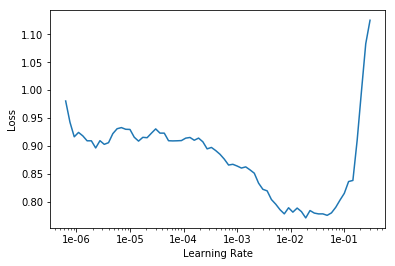

In [28]:

learn.lr_find()
learn.recorder.plot()

In [235]:
learn.unfreeze()

In [29]:
learn.fit_one_cycle(1, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,precision,recall
1,0.702944,0.639955,0.561538,0.543478,0.769231


In [342]:
learn.save('predict-pneumothorax-patient-split-1')

In [452]:
learn.load('predict-pneumothorax-patient-split-1')
1

1

In [ ]:
lr = 1e-2
lrs = np.array([lr/9,lr/3,lr])
learn.unfreeze()
learn.fit_one_cycle(max_lr = lrs,  cyc_len=1)

In [35]:
doc(create_cnn)

In [30]:
learn.unfreeze()


In [31]:
learn.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


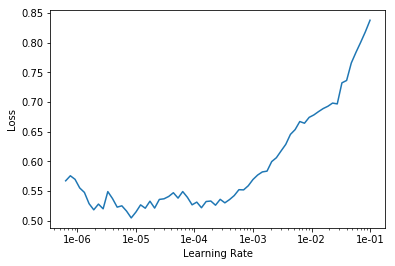

In [32]:
learn.recorder.plot()

In [101]:
learn.loss_func.func

CrossEntropyLoss()

In [33]:
learn.fit_one_cycle(30, max_lr=slice(1e-6,3e-6))

epoch,train_loss,valid_loss,accuracy,precision,recall
1,0.576723,0.560617,0.723077,0.704225,0.769231
2,0.544648,0.514761,0.823077,0.850000,0.784615
3,0.562583,0.548077,0.815385,0.901961,0.707692
4,0.549449,0.529109,0.830769,0.905660,0.738462
5,0.569700,0.514963,0.823077,0.903846,0.723077
6,0.574328,0.490671,0.830769,0.877193,0.769231
7,0.563188,0.506998,0.815385,0.901961,0.707692
8,0.560011,0.502731,0.807692,0.857143,0.738462
9,0.566797,0.485567,0.830769,0.877193,0.769231
10,0.562066,0.476362,0.830769,0.877193,0.769231


In [34]:

preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(data, preds, y, losses)


In [35]:
interp.top_losses()


(tensor([5.0261e+00, 3.3106e+00, 3.2965e+00, 3.1717e+00, 2.6713e+00, 2.6599e+00,
         2.4899e+00, 2.0101e+00, 1.9336e+00, 1.8733e+00, 1.4406e+00, 1.3907e+00,
         1.3845e+00, 1.3363e+00, 1.1134e+00, 1.0849e+00, 1.0496e+00, 8.9415e-01,
         8.3915e-01, 8.2635e-01, 7.7656e-01, 6.7209e-01, 6.7180e-01, 6.1397e-01,
         5.9116e-01, 5.8001e-01, 5.5058e-01, 5.4144e-01, 5.1374e-01, 4.9493e-01,
         4.8524e-01, 4.5767e-01, 4.5165e-01, 4.5138e-01, 4.4506e-01, 4.4494e-01,
         4.1913e-01, 4.0038e-01, 3.8243e-01, 3.5449e-01, 3.3495e-01, 3.3315e-01,
         2.9455e-01, 2.9185e-01, 2.7734e-01, 2.7253e-01, 2.7077e-01, 2.4982e-01,
         2.4463e-01, 2.4421e-01, 2.4304e-01, 2.4232e-01, 2.3907e-01, 2.1626e-01,
         2.0392e-01, 2.0374e-01, 1.9867e-01, 1.9520e-01, 1.9191e-01, 1.8975e-01,
         1.8055e-01, 1.8007e-01, 1.7436e-01, 1.6988e-01, 1.6543e-01, 1.6189e-01,
         1.6059e-01, 1.5943e-01, 1.5821e-01, 1.5697e-01, 1.5686e-01, 1.5377e-01,
         1.3514e-01, 1.2252e

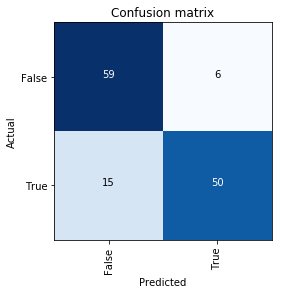

In [36]:
interp.plot_confusion_matrix()


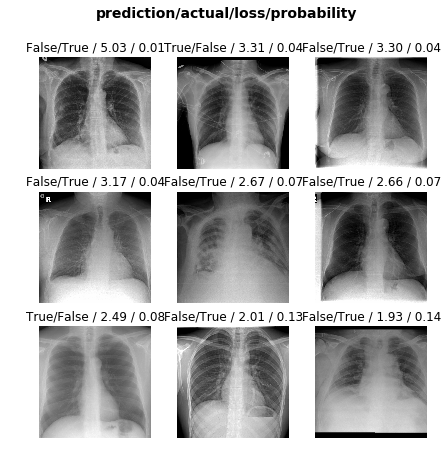

In [37]:
interp.plot_top_losses(9, figsize=(7,7))

In [380]:
interp.top_losses()[1][14:0]

tensor([], dtype=torch.int64)

ImageID    65746294648463113187537766143085082493_qyb7xg.png
Name: 2, dtype: object
[['pneumothorax', 'loc right', 'loc apical'], ['pneumothorax', 'loc right', 'loc apical'], ['pneumothorax', 'loc apical'], ['normal'], ['exclude']]
Actual Pneumothorax: True
Predicted Pneumothorax: True


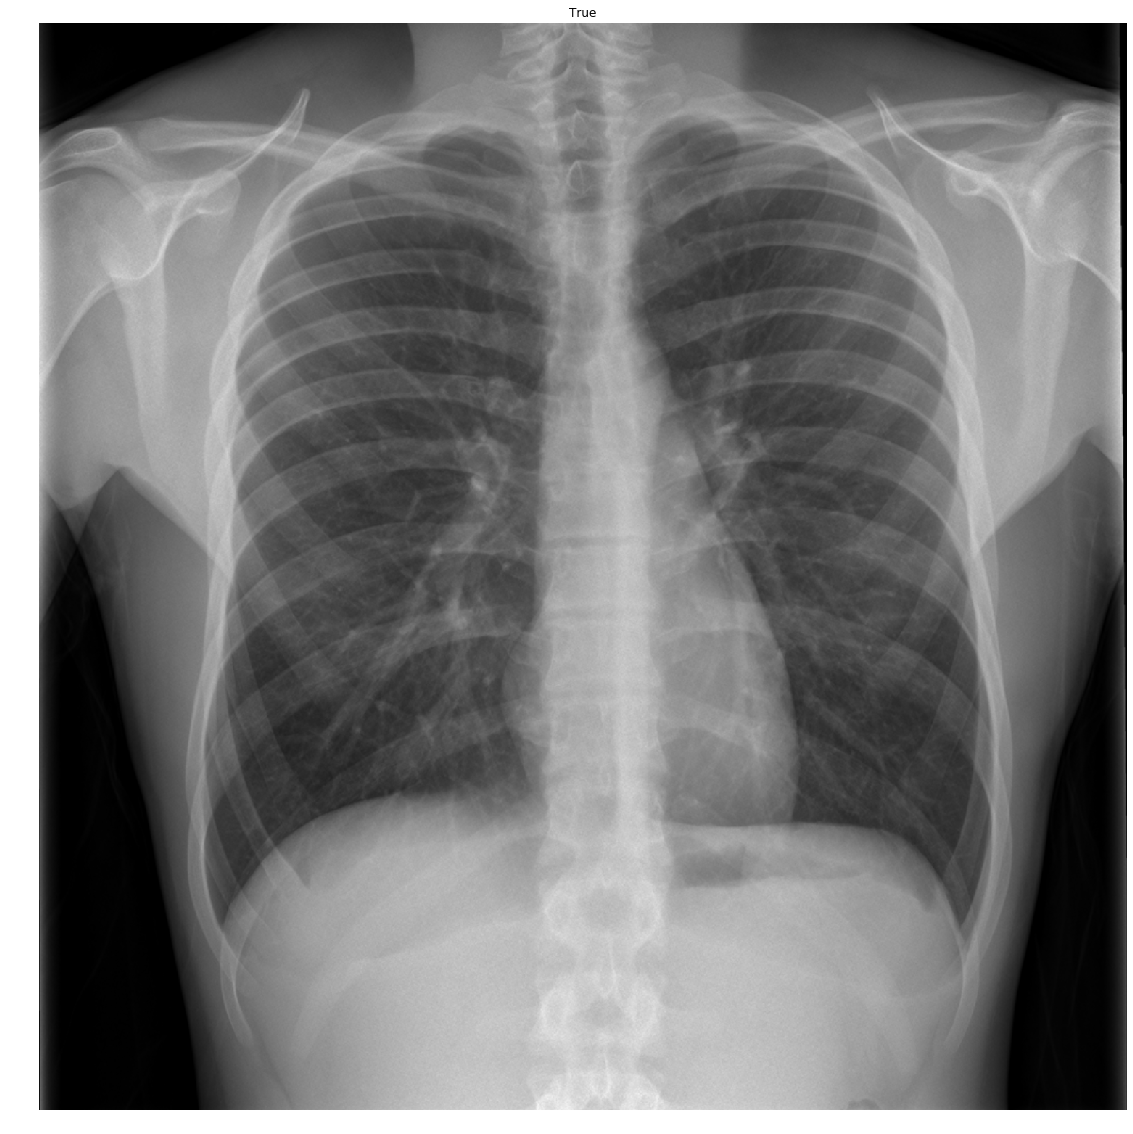

In [112]:
#Normal = 0, pneumothorax= 1 
#21,  42,  77, 107,  79,  76,  91,  61,  92, 105, 106,  89,  72, 120,
item =2
img,labels = data.valid_ds[item]


print(df_final.loc[val.index.values[item], ['ImageID']])
print(df_final.loc[val.index.values[item], 'LabelsLocalizationsBySentence'])

print('Actual Pneumothorax: {}'.format(labels))
predicted = bool(np.argmax(preds[item], axis=0))
print('Predicted Pneumothorax: {}'.format(predicted))
img.show(title=labels, figsize=(20,20) )


In [41]:
#HeatMap
m = learn.model.eval().half()
m#.half()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [492]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [16, 64, 512, 512]   9408       False     
______________________________________________________________________
BatchNorm2d          [16, 64, 512, 512]   128        True      
______________________________________________________________________
ReLU                 [16, 64, 512, 512]   0          False     
______________________________________________________________________
MaxPool2d            [16, 64, 256, 256]   0          False     
______________________________________________________________________
Conv2d               [16, 64, 256, 256]   36864      False     
______________________________________________________________________
BatchNorm2d          [16, 64, 256, 256]   128        True      
______________________________________________________________________
ReLU                 [16, 64, 256, 256]   0          False     
______________________________________________________________

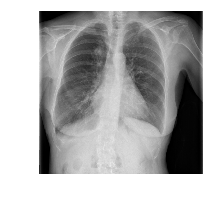

In [133]:
item =2
x,y = data.valid_ds[item]
x.show()
#data.valid_ds.y[idx]

In [134]:

xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda().half()


In [135]:
from fastai.callbacks.hooks import *


In [136]:
def hooked_backward(cat= y):
  
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [137]:
hook_a,hook_g = hooked_backward()

In [138]:
hook_a.stored.size()

torch.Size([1, 512, 47, 47])

In [139]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 47, 47])

In [140]:
acts = acts.to(torch.float32)
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([47, 47])

In [141]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.7, extent=(0,1500,1500,0),
              interpolation='bilinear', cmap='magma');

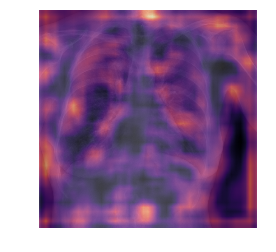

In [142]:
show_heatmap(avg_acts)

In [143]:
print(data.train_ds)

LabelList
y: CategoryList (516 items)
[Category True, Category True, Category True, Category True, Category True]...
Path: /home/auri/SJ
x: MyImageItemList (516 items)
[Image (3, 1024, 1075), Image (3, 1041, 1024), Image (3, 1038, 1024), Image (3, 1041, 1024), Image (3, 1245, 1024)]...
Path: /home/auri/SJ


In [144]:
print(data.valid_ds.x[0])

Image (3, 1024, 1245)
